In [1]:
import arcgis
import arcgiskey
from arcgis.gis import GIS
from arcgis.geometry import *
from ipywidgets import *
import geopandas as gpd
import pandas as pd
import numpy as np
import arcgis.network as network
import arcgis.geocoding as geocoding
from arcgis.features import (
    FeatureLayer,
    FeatureSet,
    FeatureCollection,
    FeatureLayerCollection,
    GeoAccessor,
    GeoSeriesAccessor,
)
import arcgis.features.use_proximity as use_proximity
from arcgis.geoenrichment import *
from arcgis.map.symbols import PictureMarkerSymbolEsriPMS
from arcgis.map.symbols import (
    SimpleFillSymbolEsriSFS,
    SimpleLineSymbolEsriSLS,
    SimpleMarkerSymbolEsriSMS,
)
from arcgis.map import renderers
from arcgis.map.renderers import SimpleRenderer
from arcgis.map.symbols import SimpleFillSymbolEsriSFS, SimpleFillSymbolStyle
from arcgis.map.symbols import SimpleLineSymbolEsriSLS, SimpleLineSymbolStyle
from shapely.geometry import (
    Point,
    MultiPoint,
    LineString,
    MultiLineString,
    Polygon,
    MultiPolygon,
)

gis = GIS(username = arcgiskey.USERNAME, password = arcgiskey.PASSWORD)

# 1) Project Title: Identifying points of Traffic with reasons in San Diego

Team Members: Kevin Wong (A17280855) and Lukas Fullner (A16945107) 

Class: DSC 170 Winter 2025

# 2) Questions we want to address, and their importance

Traffic Pattern Analysis
* How does traffic in urban, suburban, and rural areas differ? Specifically, what type of accidents happen most often in each respective category?
* What are the most accident-prone intersections, highways, and roads in San Diego? Identify high risk areas based on accident frequency and severity

Accident Causes & Trends:
* How does traffic congestion correlate with accident occurrences?

Demographic Factors: 
* Are accidents more frequent in areas with certain demographic characteristics?
* Do different types of accidents correlate with socioeconimic factors?

When traffic accidents are portrayed on the news, they are cited as being avoidable and oftentimes the cause of reckless driving, whether that be through sleepy drivers or those under the influence. However, we propose that oftentimes, traffic is not solely caused by reckless driving and individual driver behvaior. Other factors - such as socioeconomic conditions, infrastructure design, and traffic congrestion - play a significant role and are more measurable than human error. 

By identifying areas with high traffic volume and frequent accidents (relative to their area), we aim to create an interactive map highlighting accident-prone locations and potential contributing factors. This will provide a data-driven approach to understanding traffic safety in San Diego county and offer potential areas of improve to reduce accidents.

# 3) Background and Literature

GIS in Traffic Accident Analysis

* GIS has been extensively used to study the spatial distribution of traffic accidents, identifying hotspots and danger points in road traffic. For instance, the [FeGIS](https://bmdv.bund.de/SharedDocs/DE/Artikel/DG/mfund-projekte/frueherkennung-von-gefahrenstellen-im-strassenverkehr-fegis.html) (Early Detection of Dangerous Areas in road traffic) project in Germany helped identify these "danger points", preventing accidents through timely warnings of danger zones for pedestrians and road users. It offered an outline for proactive identification of danger for EU Road Safety Policy

Statistical Methods in Traffic Safety Research 

* Statistical and econometrical methods for analyzing crash data and understanding the factors that influence accident occurrences and severities are essential to our project. Researchers like [Fred Mannering](https://en.wikipedia.org/wiki/Fred_Mannering) have contributed significantly to this field, developing models that account for accident frequency and severity based on road conditions, type, and more. 

Tools for Spaital Analysis in Traffic Studies

* Tools like [CrimeStat](https://en.wikipedia.org/wiki/CrimeStat) offer spatial statistical functionalities that can be applied to traffic accident analysis. CrimeStat's spatial analytical methods have been adapted for various applications, like finding accident hotspots and modeling travel demand related to traffic accidents.

# 4) Libaries and Modules

* Pandas - To handle dataframes and to preprocess data
* GeoPandas — Used to determine the geometry of certain places in San Diego. Also used to help spatial join and create buffers around areas to analyze them.
* ArcGIS Online — Mainly used for Geoenrichment as well as mapping traffic patterns around a map of San Diego. Additionally, used to search for data in ArcGIS to see which areas have a lot of traffic and see what correlations are implied with it. 

# 5) Data Sources:

SANDAG: Safety - Collions (SWITRS) 2023 
* This data focuses on collision data for San Diego within 2022, due to it's completeness. It currently has over 10000 collisions in San Diego County. Primarily, it uses the Statewide Integrated Traffic Records System (SWITRS) as a database and process data gathered from a collision scene. We take this specifically from SANDAG due to their reliability as a data distributor for spatial data with the help of California Highway Patrol. We will be using data primarily from 2023. 

ArcGIS Online USA Counties 
* Used to determine the counties in the United States; additionally, used for geoenrichment to find population density

In [ ]:
# read data and convert into a spatial dataframe
data = gpd.read_file("data/collision_data_2022.csv")
data = data.drop(columns = ['Reservation sandag', 'Shape', 'CASE ID', 'X', 'Y'])

# conver to floats in order to make sure the spatial references work
data['LONGITUDE sandag'] = data['LONGITUDE sandag'].astype(float)
data['LATITUDE sandag'] = data['LATITUDE sandag'].astype(float)
sdf = GeoAccessor.from_xy(data, x_column='LONGITUDE sandag', y_column='LATITUDE sandag', sr = 4326)

In [ ]:
# convert into a feature layer -> DON'T RUN AGAIN, ALREADY CREATED
# feature_layer = sdf.spatial.to_featurelayer(
#     title = "Collision Data SD County 2022",
#     gis = gis, 
#     tags = ["Collision", "Data", "2022"],
#     overwrite = False,
#     sanitize_columns = True,
#     service_name = "Collision_Data_San_Diego_County_2022"
# )

In [7]:
collision_layer = gis.content.search(query = "owner:dsc170wi25_7", item_type = "Feature Layer", outside_org = True)[0]
collision_fl = gis.content.get(collision_layer.id).layers[0]
collision_sdf = collision_fl.query().sdf

In [8]:
# find county barrier for San Dieg
counties = gis.content.search("USA Counties generalized", "Feature Layer", outside_org=True)[4]
counties_fl = gis.content.get(counties.id).layers[0]
sd_county_sdf = counties_fl.query("NAME = 'San Diego County'", return_geometry=True).sdf
sd_county_gdf = gpd.GeoDataFrame(sd_county_sdf).set_geometry("SHAPE")
sd_county_gdf = sd_county_gdf.set_crs("4326")
sd_county_gdf = sd_county_gdf.to_crs("3857")

# find US zip codes for San Diego
zip_codes = gis.content.search("zip code", item_type = "Feature Layer", outside_org = True)[2]
zip_codes_fl = gis.content.get(zip_codes.id).layers[0]
california_zip_codes_sdf = zip_codes_fl.query(where = "STATE = 'CA'").sdf
ca_zip_codes_gdf = gpd.GeoDataFrame(california_zip_codes_sdf).set_geometry("SHAPE")
ca_zip_codes_gdf = ca_zip_codes_gdf.set_crs("3857")

# spatial join these two to find zip codes that lie within San Diego County (add buffer to get rid of inconsistencies)
sd_county_gdf['SHAPE'] = sd_county_gdf['SHAPE'].buffer(5000)
sd_zip_codes = ca_zip_codes_gdf.sjoin(sd_county_gdf, predicate = 'within')

# create 'density_class' based on 'pop_sqmi_l'
def classify_density(pop_density):
    if pop_density > 1000:
        return "Urban"
    elif pop_density > 200:
        return "Suburban"
    else:
        return "Rural"

# fill the missing value with data from 2023
sd_zip_codes["POP_SQMI_left"] = sd_zip_codes["POP_SQMI_left"].fillna(3860)
sd_zip_codes["density_class"] = sd_zip_codes["POP_SQMI_left"].apply(classify_density)

Exception: Cannot perform query. Invalid query parameters.
'Invalid field: STATE' parameter is invalid
(Error Code: 400)

In [ ]:
# convert into feature layer -> don't run again, already created
# sd_zip_sdf = GeoAccessor.from_geodataframe(
#     sd_zip_codes, column_name = "SHAPE"
# )
# zip_code_fl = sd_zip_sdf.spatial.to_featurelayer(
#     title = "San Diego County Zip Codes",
#     gis = gis,
#     tags = ["San Diego", "Zip Codes", "County"],
#     overwrite = False,
#     sanitize_columns = True,
#     service_name = "San_Diego_County_ZipCode_Data"
# )

In [ ]:
zip_code_layer = gis.content.search(
    query="owner:dsc170wi25_7", item_type="Feature Layer"
)[1]
sd_zip_codes_fl = gis.content.get(zip_code_layer.id).layers[0]
sd_zip_codes_sdf = sd_zip_codes_fl.query().sdf

In [ ]:
map1 = gis.map("San Diego, CA")

# population density renderer
population_density_renderer = {
    "type": "uniqueValue",
    "field1": "density_cl",
    "uniqueValueInfos": [
        {
            "value": "Urban",
            "symbol": {
                "type": "esriSFS",
                "style": "esriSFSSolid",
                "color": [252, 101, 66, 100],  # Transparent fill
                "outline": {
                    "color": [252, 101, 66, 255],  # Red outline for urban areas
                    "width": 1.5,
                },
            },
            "label": "Urban",
        },
        {
            "value": "Suburban",
            "symbol": {
                "type": "esriSFS",
                "style": "esriSFSSolid",
                "color": [162, 190, 149, 100],  # Transparent fill
                "outline": {
                    "color": [162, 190, 149, 255],  # Green outline for suburban areas
                    "width": 1.5,
                },
            },
            "label": "Suburban",
        },
        {
            "value": "Rural",
            "symbol": {
                "type": "esriSFS",
                "style": "esriSFSSolid",
                "color": [55, 94, 151, 100],  # Transparent fill
                "outline": {
                    "color": [55, 94, 151, 255],  # Blue outline for rural areas
                    "width": 1.5,
                },
            },
            "label": "Rural",
        },
    ],
}

map1.content.add(
    sd_zip_codes_fl, drawing_info={"renderer": population_density_renderer}
)
map1.content.add(collision_fl)
map1.legend.enabled = True
map1


Map(center=[3857636.3466711883, -13042616.481232138], extent={'xmin': -13075789.689488532, 'ymin': 3818273.910…

# 6) Expected Data Cleaning

Some relevant data quality issues is data age. We want to use more modern data, but also have data that is complete and accurate. We already did this with the collision data, as 2023 and 2024 data were incomplete, which means we had to settle for 2022. However, 2022 is a decent predictor of 2024 and 2025, as the bounceback from COVID had already begun. Fortunately, a topic like traffic accidents is a pretty popular and normal set that is used in data analysis, so there shouldn’t be any problems with it’s metadata. I would expect a lot of the data provided in SANDAG to be mostly reputable, but I do expect some problems with street names or areas that might not have been mapped out that well in the data. We will also encounter the issue of incomplete reporting, where the SANDAG data may not have full information reported for certain fields meaning we will have to impute some data or otherwise acount for the missing data.

Additionally, some data cleaning we had to do was due to the buffer, since the boundaries of the county weren't 100% accurate to the boundaries of the zip code. We had to place a 5000 meter buffer on the county in order to get all of the zip codes in the county.

# 7) Plan of Analysis

* Data Exploration - Look through the data to see what exactly there is to analyze. For example, for traffic accidents, we could analyze how serious an accident is, or see what type of accident it is (this could be a car-car accident, car-person accident, car-bike accident, etc)
* Data Analysis - We could look at concentrated places on our map where accidents occur more, and geoenrich a specific part (i.e. Downtown San Diego) to understand why something is happening. For instance, if we saw a lot of traffic in an area along with a lot of pedestrian violence, there might be a higher chance that an accident occurs. Similarly, we could also check restaurants that serve alcohol, and analyze whether or not areas near the restaurants could serve as an indication of an accident happening.
* Machine Learning/Modeling - We want to model whether or not accidents are more likely to occur based on a number of variables that we had geoenriched. This could be the aforementioned # of restaurants that serve alcohol, or any sort of number of features that we geoenriched previously, and make sure we have a set of test areas that could be predicted. We could also predict the type of accident that happened spatially, with the same features. For our business case, we could identify certain zip codes or areas that contain a lot of traffic, and see reasons why they might be so traffic heavy compared to other zip codes. 


For the first question, we observed whether or not collisions were more likely to occur in urban, rural, or suburban areas, as well as which zip codes had the highest collision density. We found per square kilometer, Rural Areas only had 0.001673 collisions, Suburban Areas had 0.003585 collisions, while Urban had by far the highest collision density, with 0.021066 collisions per square kilometer. We also noticed that when we measured collision density in individual zip codes, those closest to the coast and downtown near the freeway had the highest collision rate, which is to be expected due to their frequent usage.

In [15]:
# Let's see if accidents are more prone to happening in urban, suburban, or rural areas
collision_gdf = gpd.GeoDataFrame(collision_sdf, geometry=collision_sdf.SHAPE)
sd_zip_codes_gdf = gpd.GeoDataFrame(sd_zip_codes_sdf, geometry=sd_zip_codes_sdf.SHAPE)
zip_code_collisions = collision_gdf.sjoin(sd_zip_codes_gdf, predicate="within")

In [16]:
# see which zip codes are most accident prone
collision_counts = zip_code_collisions.groupby("zip_code").size().rename("Total Collisions")

# convert from m2 -> km2
total_area = zip_code_collisions.groupby("zip_code")['shape_area'].sum().rename("Total Area") / 1000000
collision_density = (collision_counts / total_area).rename("Collision Density")

zip_code_collision_density = sd_zip_codes_sdf.merge(collision_density, left_on = "zip_code", right_index = True, how = "outer")
zip_code_collision_density['Col_Dens_km'] = zip_code_collision_density['Collision Density'].fillna(0)
zip_code_collision_density = zip_code_collision_density.set_geometry("SHAPE")
zip_code_collision_density = zip_code_collision_density.set_crs("3857")

KeyError: 'zip_code'

In [ ]:
zip_collision_density_sdf = GeoAccessor.from_geodataframe(
    zip_code_collision_density, column_name="SHAPE"
)
zip_collision_density_fl = zip_collision_density_sdf.spatial.to_featurelayer(
    title="San Diego County Zip Code Collision Density",
    gis=gis,
    tags=["San Diego", "Zip Codes", "Collision Density"],
    overwrite=False,
    sanitize_columns=True,
    service_name="San_Diego_County_Zip_Code_Collision_Density",
)

In [ ]:
zip_collision_layer = gis.content.search(query="owner:dsc170wi25_31", item_type="Feature Layer")[3]
zip_col_fl = gis.content.get(zip_collision_layer.id).layers[0]
zip_col_sdf = zip_col_fl.query().sdf

In [17]:
map2 = gis.map("San Diego, CA")
# Apply a graduated colors renderer
density_renderer = {
    "type": "classBreaks",
    "field": "col_dens_k",
    "classificationMethod": "esriClassifyQuantile",
    "minValue": 0,
    "maxValue": 1.3,
    "defaultSymbol": {
        "type": "esriSFS",
        "style": "esriSFSSolid",
        "color": [255, 255, 255, 100],
        "outline": {
            "type": "esriSLS",
            "style": "esriSLSSolid",
            "color": [110, 110, 110, 255],
            "width": 0.5,
        },
    },
    "defaultLabel": "No Data",
    "legendOptions": {"title": "Collision Density (per sq km)"},
    "classBreakInfos": [
        {
            "classMaxValue": np.percentile(zip_col_sdf["col_dens_k"], 25),
            "symbol": {
                "type": "esriSFS",
                "style": "esriSFSSolid",
                "color": [204, 236, 230, 100],  # Light blue-green
                "outline": {
                    "color": [110, 110, 110, 255],
                    "width": 0.5,
                    "type": "esriSLS",
                    "style": "esriSLSSolid",
                },
            },
            "label": "1st-25th Percentile",
        },
        {
            "classMaxValue": np.percentile(zip_col_sdf["col_dens_k"], 50),
            "symbol": {
                "type": "esriSFS",
                "style": "esriSFSSolid",
                "color": [153, 216, 201, 100],  # Medium blue-green
                "outline": {
                    "color": [110, 110, 110, 255],
                    "width": 0.5,
                    "type": "esriSLS",
                    "style": "esriSLSSolid",
                },
            },
            "label": "25th-50th Percentile",
        },
        {
            "classMaxValue": np.percentile(zip_col_sdf["col_dens_k"], 75),
            "symbol": {
                "type": "esriSFS",
                "style": "esriSFSSolid",
                "color": [102, 194, 164, 100],  # Darker blue-green
                "outline": {
                    "color": [110, 110, 110, 255],
                    "width": 0.5,
                    "type": "esriSLS",
                    "style": "esriSLSSolid",
                },
            },
            "label": "50th-75th Percentile",
        },
        {
            "classMaxValue": np.percentile(zip_col_sdf["col_dens_k"], 100),
            "symbol": {
                "type": "esriSFS",
                "style": "esriSFSSolid",
                "color": [0, 109, 44, 255],  # Dark green
                "outline": {
                    "color": [110, 110, 110, 255],
                    "width": 0.5,
                    "type": "esriSLS",
                    "style": "esriSLSSolid",
                },
            },
            "label": "75th-100th Percentile",
        },
    ],
}


# Add the layer with the heatmap renderer to your map
map2.content.add(zip_col_fl, drawing_info={"renderer": density_renderer})
map2.legend.enabled = True
map2


NameError: name 'zip_col_sdf' is not defined

In [46]:
# Lets now evaluate lane size relative to collisions
# read data and convert into a spatial dataframe
road_data = gpd.read_file("data/SOC_Road_data.csv")
road_data = road_data.drop(columns = ['Speed 2021 MPH', '2021 AADT Range', "1 year AADT % change", "1 year Speed % change"])



# conver to floats in order to make sure the spatial references work
#data['LONGITUDE sandag'] = data['LONGITUDE sandag'].astype(float)
#data['LATITUDE sandag'] = data['LATITUDE sandag'].astype(float)
#sdf = GeoAccessor.from_xy(data, x_column='LONGITUDE sandag', y_column='LATITUDE sandag', sr = 4326)

In [49]:
road_data['Speed 2022 MPH'].unique()

array([18.0, 16.9, 16.2, 16.5, 36.5, 35.6, 18.3, 15.5, 39.4, 36.7, 33.5,
       29.2, 28.5, 26.0, 24.0, 22.6, 30.6, 25.0, 29.9, 25.5, 17.7, 14.5,
       34.7, 22.3, 19.6, 17.3, 20.0, 24.4, 33.1, 33.3, 19.5, 18.4, 39.7,
       40.3, 20.2, 29.7, 27.5, 23.3, 21.5, 21.2, 18.2, <NA>, 23.5, 26.6,
       20.3, 27.8, 26.5, 26.7, 24.7, 18.8, 22.0, 19.8, 32.1, 18.6, 31.3,
       32.6, 16.1, 15.2, 21.9, 25.7, 19.4, 15.4, 28.1, 26.4, 21.0, 50.0,
       50.7, 23.4, 47.5, 43.6, 14.8, 13.3, 17.5, 14.0, 13.4, 35.9, 30.1,
       15.9, 14.3, 25.1, 23.1, 30.0, 31.9, 25.8, 45.6, 46.2, 26.3, 23.9,
       28.7, 27.0, 27.3, 52.9, 54.5, 52.1, 53.6, 27.2, 38.4, 36.8, 23.6,
       22.9, 15.0, 29.6, 32.3, 30.3, 24.6, 18.9, 20.4, 34.5, 32.7, 8.1,
       9.1, 30.9, 24.9, 23.0, 29.1, 27.9, 28.8, 34.3, 36.1, 43.4, 42.8,
       44.2, 42.9, 33.7, 34.2, 21.8, 20.9, 20.5, 16.8, 26.2, 23.2, 30.5,
       31.2, 31.4, 32.8, 31.0, 33.2, 31.1, 30.4, 28.6, 23.8, 34.1, 28.3,
       29.5, 22.4, 21.6, 37.7, 35.8, 41.4, 39.9, 28.9

In [52]:
cols = ['osm_id', 'Speed Limit MPH', 'Lanes', 'Length', 'Speed 2022 MPH']

road_data = road_data.convert_dtypes()
road_data['Speed 2022 MPH'] = road_data['Speed 2022 MPH'].replace('<NA>', '0')
road_data[cols] = road_data[cols].apply(pd.to_numeric, errors='coerce', axis=1)
#road_data['Speed 2022 MPH'] = road_data['Speed 2022 MPH'].astype(float)

In [53]:
road_data.dtypes

osm_id                    Float64
Street Name        string[python]
Highway            string[python]
Lanes                     Float64
Speed Limit MPH           Float64
Length                    Float64
Direction          string[python]
PeakPeriod         string[python]
Speed 2022 MPH            Float64
2022 AADT Range    string[python]
geometry           string[python]
dtype: object

In [54]:
road_data.head(3)

,osm_id,Street Name,Highway,Lanes,Speed Limit MPH,Length,Direction,PeakPeriod,Speed 2022 MPH,2022 AADT Range,geometry
0,153343706.0,"Orange Avenue, CA 75",primary,2.0,40.0,43.61,S,AM,18.0,"10,000-19,999",LINESTRING (-117.178938176757 32.6836120192024...
1,153343706.0,"Orange Avenue, CA 75",primary,2.0,40.0,43.61,S,PM,16.9,"10,000-19,999",LINESTRING (-117.178938176757 32.6836120192024...
2,161508068.0,Nimitz Boulevard,primary,-1.0,40.0,41.71,SE,AM,16.2,"5,000-9,999",LINESTRING (-117.221695942172 32.7260512722891...


In [59]:
from shapely.wkt import loads

road_gdf = gpd.GeoDataFrame(road_data)
road_gdf['geometry'] = road_gdf['geometry'].apply(lambda x: loads(x) if isinstance(x, str) else x)

In [64]:
road_gdf = road_gdf.set_geometry('geometry')
road_gdf = road_gdf.set_crs(4326)
road_gdf.geometry

0        LINESTRING (-117.17894 32.68361, -117.17892 32...
1        LINESTRING (-117.17894 32.68361, -117.17892 32...
2        LINESTRING (-117.2217 32.72605, -117.22163 32....
3        LINESTRING (-117.2217 32.72605, -117.22163 32....
4        LINESTRING (-117.19576 32.74574, -117.19493 32...
                               ...                        
78307    LINESTRING (-117.24993 33.3662, -117.24989 33....
78308    LINESTRING (-117.24146 33.41379, -117.24133 33...
78309    LINESTRING (-117.24146 33.41379, -117.24133 33...
78310    LINESTRING (-117.23999 33.19747, -117.23999 33...
78311    LINESTRING (-117.23999 33.19747, -117.23999 33...
Name: geometry, Length: 78312, dtype: geometry

<Axes: >

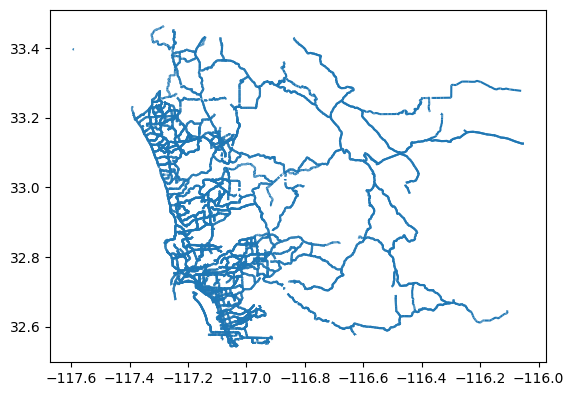

In [65]:
road_gdf.plot()

In [ ]:
# Feature layer for road data
# road_sdf = GeoAccessor.from_geodataframe(
#     road_gdf, column_name = "geometry"
# )
# feature_layer = road_sdf.spatial.to_featurelayer(
#     title = "Road Data SD County 2022",
#     gis = gis, 
#     tags = ["Road", "Data", "2022"],
#     overwrite = False,
#     sanitize_columns = True,
#     service_name = "Road_Data_San_Diego_County_2022"
# )

In [2]:
road_layer = gis.content.search(query="owner:dsc170wi25_7 Road", item_type="Feature Layer")[0]
road_fl = gis.content.get(road_layer.id).layers[0]
road_sdf = road_fl.query().sdf

In [3]:
road_sdf.lanes.unique()

<FloatingArray>
[2.0, -1.0, 3.0, 4.0, 1.0, 5.0, 6.0, 7.0, 0.0]
Length: 9, dtype: Float64

In [5]:
map3 = gis.map("San Diego, CA")

road_renderer = {
    "type": "classBreaks",
    "field": "lanes",  # Attribute that determines line width
    "defaultSymbol": {
        "type": "esriSLS",
        "style": "esriSLSSolid",
        "color": [128, 128, 128, 255],  # Gray color for undefined values
        "width": 1  # Default width
    },
    "classBreakInfos": [
        {
            "classMinValue": 1,
            "classMaxValue": 1,
            "symbol": {
                "type": "esriSLS",
                "style": "esriSLSSolid",
                "color": [0,0,255, 255], 
                "width": 2  
            }
        },
        {
            "classMinValue": 2,
            "classMaxValue": 2,
            "symbol": {
                "type": "esriSLS",
                "style": "esriSLSSolid",
                "color": [64,224,208, 255],
                "width": 3  
            }
        },
        {
            "classMinValue": 3,
            "classMaxValue": 3,
            "symbol": {
                "type": "esriSLS",
                "style": "esriSLSSolid",
                "color": [0,255,127, 255], 
                "width": 4  
            }
        },
        {
            "classMinValue": 4,
            "classMaxValue": 4,
            "symbol": {
                "type": "esriSLS",
                "style": "esriSLSSolid",
                "color": [127,255,0, 255],
                "width": 5 
            }
        },
        {
            "classMinValue": 5,
            "classMaxValue": 5,
            "symbol": {
                "type": "esriSLS",
                "style": "esriSLSSolid",
                "color": [255,255,0, 255], 
                "width": 6  
            }
        },
        {
            "classMinValue": 6,
            "classMaxValue": 6,
            "symbol": {
                "type": "esriSLS",
                "style": "esriSLSSolid",
                "color": [255,140,0, 255], 
                "width": 7 
            }
        },
        {
            "classMinValue": 7,
            "classMaxValue": 7,
            "symbol": {
                "type": "esriSLS",
                "style": "esriSLSSolid",
                "color": [220,20,60, 255],
                "width": 8  
            }
        }
    ]
}

map3.content.add(road_sdf, drawing_info={"renderer": road_renderer})
map3.legend.enabled = True
map3

Map(center=[3857636.3466711883, -13042616.481232138], extent={'xmin': -13075789.689488532, 'ymin': 3818273.910…

In [9]:
map4 = gis.map('San Diego, CA')

map4.content.add(collision_fl)
map4.content.add(road_sdf, drawing_info={"renderer": road_renderer})
map4.legend.enabled = True
map4

Map(center=[3857636.3466711883, -13042616.481232138], extent={'xmin': -13075789.689488532, 'ymin': 3818273.910…

# 8) Expected Spatial Data Integration Issues

Some issues of the data could be that the San Diego county data might use NAD83 state plane EPSG:2230 while others might use EPSG:4326 which can be an easy fix. There might be temporal alignment issues however, as there could be time issues between years like 2020 or 2023. There might even be incomplete data from say, 2024. 
